In [1]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json
from nltk import PorterStemmer, bigrams as nltk_bigrams
import re
from nltk.corpus import stopwords
from functools import lru_cache

sns.set_style("darkgrid")

# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

### Constants and function definitions

In [ ]:
REVIEW_DATA_FILE = 'Movies_and_TV.jsonl'
META_DATA_FILE = "meta_Movies_and_TV.jsonl"

In [3]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

## 1. Data processing

### Process meta data

In [56]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

df_meta.limit(5)

title,average_rating,rating_number,description,price,categories,content_advisory,asin,desc_len
str,f64,i64,str,f64,list[str],list[str],str,u32
"""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",-1.0,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19
"""Ode to Joy: Beethoven's Sympho…",4.3,35,"""This special Ode to Joy: Beeth…",5.99,"[""Documentary""]",[],"""B01G9ILXXE""",234
"""Ben 10: Alien Force (Classic)""",4.7,360,"""Itâ€™s hero time again for Ben…",24.49,"[""Science Fiction"", ""Comedy"", … ""Drama""]",[],"""B009SIYXDA""",377


In [57]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("desc_len"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
)

best_per_title.limit(5)

title,asins,average_rating,rating_number,description,desc_len,price,categories,content_advisory
str,list[str],f64,i64,str,u32,f64,list[str],list[str]
"""Cry of the City (1948)""","[""B005REEYGK""]",4.5,75,"""Petty crook and cop-killer Mar…",469,-1.0,"[""Movies & TV"", ""Movies""]",[]
"""MI-5, Vol. 6""","[""B001EHF3RS""]",4.2,443,"""Product Description""",19,34.02,"[""Movies & TV"", ""BBC"", ""All BBC Titles""]",[]
"""2 Broke Girls - Season 1-3 [DV…","[""B00DY64AXA""]",4.3,195,"""""",0,42.21,"[""Movies & TV"", ""TV""]",[]
"""Yesterday/Lost Memories""","[""B001QUXNNE""]",5.0,1,"""YESTERDAY/LOST MEMORIES - DVD …",35,-1.0,"[""Movies & TV"", ""Featured Categories"", … ""Foreign Films""]",[]
"""The Accompanist (All Region Im…","[""B0043FPK5S""]",5.0,4,"""""",0,-1.0,"[""Movies & TV"", ""Movies""]",[]


### Process review data

In [58]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True).filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()
df.limit(5)

rating,user_id,text,timestamp,asin
f64,str,str,i64,str
5.0,"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",1146713492000,"""B0002J58ME"""
3.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""this item was canceled. . . .n…",1556496429981,"""B000PIU2A0"""
5.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",1364088518000,"""B001JNNDRY"""
4.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""like watching: haven't gotten …",1364088147000,"""B000TSMOEI"""
4.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""pretty cool to watch: differen…",1364087577000,"""B0009MAO82"""


In [7]:
df.height, df.get_column("asin").n_unique()

(2888210, 409673)

In [8]:
best_per_title.filter(pl.col("title").is_null()).get_column("asins")[0]

""
str
"""B0059GELDW"""
"""B002W3MYZC"""
"""B09RSQFBFX"""
"""B0098VXDDS"""
"""B00GGU75N8"""
…
"""B01NAILG4J"""
"""B005HQLJ16"""
"""B07TVFHHTN"""


In [59]:
asin_title_map = best_per_title.select([
    pl.col("title"),
    pl.col("asins"),
    pl.col("average_rating"),
    pl.col("price")
]).explode("asins").rename({"asins": "asin"})

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

In [10]:
# df.get_column("asin").n_unique(), df_meta.get_column("parent_asin").n_unique()
# asins_in_df = df.get_column("asin").unique()
# asins_in_meta = df_meta.get_column("asin").unique()

# missing_asins = asins_in_df.filter(~asins_in_df.is_in(asins_in_meta.implode()))
# missing_asins.len()

In [60]:
# def filter_reviews(df, movie_threshold=5, review_threshold=5):
#     prev_rows = -1
#     while df.height != prev_rows:
#         prev_rows = df.height
#         valid_movies = (
#             df.group_by('asin')
#             .agg(pl.col('user_id').n_unique().alias('count'))
#             .filter(pl.col('count') >= review_threshold)
#             .get_column('asin')
#         )
#         df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

#         valid_reviewers = (
#             df.group_by('user_id')
#             .agg(pl.col('asin').n_unique().alias('count'))
#             .filter(pl.col('count') >= movie_threshold)
#             .get_column('user_id')
#         )
#         df = df.filter(pl.col('user_id').is_in(valid_reviewers.implode()))
#     return df

# filtered_df = filter_reviews(df)
filtered_df = df_reviews.filter(pl.col("title").is_not_null())
print(filtered_df.height)
filtered_df.limit(5)

1631725


rating,user_id,text,timestamp,asin,title,average_rating,price
f64,str,str,i64,str,str,f64,f64
5.0,"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",1146713492000,"""B0002J58ME""","""10 Minute Solution: Pilates""",4.6,8.77
3.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""this item was canceled. . . .n…",1556496429981,"""B000PIU2A0""","""Battlespace""",3.5,19.99
5.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""I grew up with this one. could…",1364088518000,"""B001JNNDRY""","""Columbo: Mystery Movie Collect…",4.7,13.4
4.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""like watching: haven't gotten …",1364088147000,"""B000TSMOEI""","""Burst Angel: Hired Gun v.4""",4.0,6.26
4.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""pretty cool to watch: differen…",1364087577000,"""B0009MAO82""","""Burst Angel, Vol. 3: East Meet…",4.7,8.49


In [12]:
reviewer_counts = (
    filtered_df.group_by('user_id')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500)
)
reviewer_counts_count = reviewer_counts.height
reviewer_counts_count

6

### Network

In [46]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('user_id')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = defaultdict(int)

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [48]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 947488/947488 [00:10<00:00, 87476.39it/s] 


8820651

In [15]:
thresholds = [2,3,4,5,7,10]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in movie_edgelist if w >= t]
    print(f"Edges with weight => {t}: {len(weighted_edges)}")

Edges with weight => 2: 96920
Edges with weight => 3: 12754
Edges with weight => 4: 4249
Edges with weight => 5: 2011
Edges with weight => 7: 700
Edges with weight => 10: 230


### Graph

In [ ]:
WEIGHT_THRESHOLD = 3
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

12754

In [61]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

In [55]:
len(G.nodes()), len(G.edges())

(9567, 12754)

In [34]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

2.666248562767848

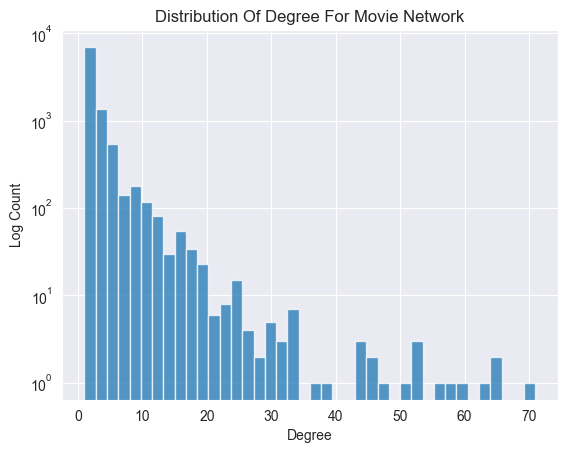

In [35]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75);

### Community detection

In [36]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [37]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [38]:
communities = louvain_partitions(G)
len(communities)

1901

In [39]:
modularity(G, communities) 

0.9380570990664

Counter({2: 1305,
         3: 307,
         4: 108,
         5: 58,
         6: 33,
         7: 20,
         8: 9,
         9: 6,
         11: 5,
         10: 4,
         24: 4,
         12: 3,
         17: 3,
         44: 2,
         20: 2,
         15: 2,
         14: 2,
         151: 1,
         175: 1,
         356: 1,
         282: 1,
         558: 1,
         307: 1,
         440: 1,
         125: 1,
         54: 1,
         103: 1,
         47: 1,
         270: 1,
         352: 1,
         111: 1,
         129: 1,
         38: 1,
         75: 1,
         101: 1,
         104: 1,
         68: 1,
         64: 1,
         36: 1,
         130: 1,
         110: 1,
         18: 1,
         23: 1,
         46: 1,
         113: 1})

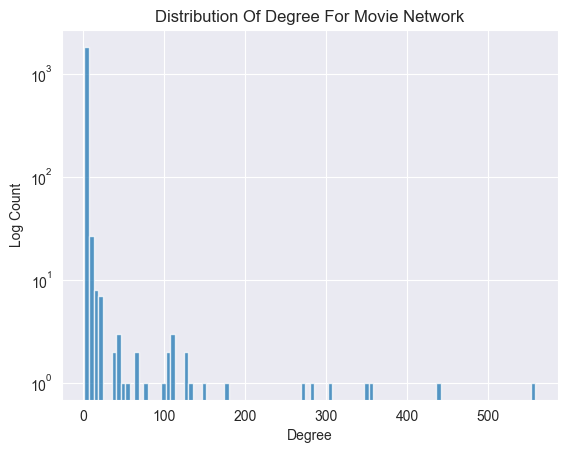

In [40]:
X = list(map(len, communities))
# X = [x for x in X if x < 100]
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

### Text analysis

In [41]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in df.columns:
    df = df.drop("community")

df = df.join(community_df, on="asin", how="left")

In [42]:
# Tokenize and stemming reviews
stemmer = PorterStemmer()
pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=10000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [cached_stem(t) for t in tokens] if stem else tokens

In [43]:
# movie_data.get_column("community").n_unique()
# movie_data.filter(pl.col("community") == 350)